In [10]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class IAMDataset(Dataset):
    def __init__(self, paths, processor, max_target_length=128):
        self.paths = paths
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        # get file name + text 
        fn = self.paths[idx]
        text = fn.split('/')[-1].split('.')[0]
        # prepare image (i.e. resize + normalize)
        image = Image.open(fn).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(
            text, 
            padding="max_length", 
            max_length=self.max_target_length
        ).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [11]:
from sklearn.model_selection import train_test_split
from transformers import TrOCRProcessor
import glob
from conf import *

all_path = glob.glob(path)
train_path, test_path = train_test_split(all_path)

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-small-printed")
train_dataset = IAMDataset(paths=train_path, processor=processor)
eval_dataset = IAMDataset(paths=test_path, processor=processor)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [12]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 963
Number of validation examples: 321


In [13]:
encoding = train_dataset[0]
for k,v in encoding.items():
    print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


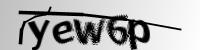

In [18]:
image = Image.open(train_path[0]).convert("RGB")
image

In [19]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

yew6p


In [21]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=16)

In [22]:
from transformers import VisionEncoderDecoderModel
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-small-printed")
model.to(device)

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-printed and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


VisionEncoderDecoderModel(
  (encoder): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTAttention(
            (attention): DeiTSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(

In [23]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [24]:
from datasets import load_metric

cer_metric = load_metric("cer")

/tmp/ipykernel_3343/152175726.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer_metric = load_metric("cer")


In [25]:
def compute_cer(pred_ids, label_ids):
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return cer

In [29]:
from transformers import AdamW
from tqdm import tqdm

optimizer = AdamW(model.parameters(), lr=5e-5)

for epoch in range(300):  # loop over the dataset multiple times
    # train
    model.train()
    train_loss = 0.0
    for batch in tqdm(train_dataloader):
        # get the inputs
        for k,v in batch.items():
            batch[k] = v.to(device)

        # forward + backward + optimize
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

    print(f"Loss after epoch {epoch}:", train_loss/len(train_dataloader))
        
    # evaluate
    model.eval()
    valid_cer = 0.0
    with torch.no_grad():
        for batch in tqdm(eval_dataloader):
            # run batch generation
            outputs = model.generate(batch["pixel_values"].to(device))
            # compute metrics
            cer = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
            valid_cer += cer 
    
    total_cer = valid_cer / len(eval_dataloader)
    print("Validation CER:", total_cer)
    if total_cer < 0.01:
        import datetime
        save_pretrained_dir = f'save/{total_cer}_{epoch}_{datetime.datetime.now(datetime.timezone(datetime.timedelta(hours=9),"JST")).strftime("%Y%m%dT%H%M%S")}'
        model.save_pretrained(save_pretrained_dir)

model.save_pretrained(".")

/home/dongha/anaconda3/envs/tc/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 61/61 [00:15<00:00,  3.87it/s]


Loss after epoch 0: 0.9013779094961824


/home/dongha/anaconda3/envs/tc/lib/python3.10/site-packages/transformers/generation/utils.py:1288: UserWarning: Using `max_length`'s default (64) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 21/21 [00:06<00:00,  3.22it/s]


Validation CER: 0.19232270349700661


100%|██████████| 61/61 [00:15<00:00,  3.87it/s]


Loss after epoch 1: 0.6423505231982372


100%|██████████| 21/21 [00:05<00:00,  3.52it/s]


Validation CER: 0.1947037539425292


100%|██████████| 61/61 [00:15<00:00,  3.85it/s]


Loss after epoch 2: 0.5786205579022892


100%|██████████| 21/21 [00:05<00:00,  3.65it/s]


Validation CER: 0.14346506950944862


100%|██████████| 61/61 [00:15<00:00,  3.88it/s]


Loss after epoch 3: 0.5790677285585247


100%|██████████| 21/21 [00:05<00:00,  3.61it/s]


Validation CER: 0.13616091906846672


100%|██████████| 61/61 [00:15<00:00,  3.88it/s]


Loss after epoch 4: 0.4604645488692112


100%|██████████| 21/21 [00:05<00:00,  3.79it/s]


Validation CER: 0.12965154803348125


100%|██████████| 61/61 [00:15<00:00,  3.88it/s]


Loss after epoch 5: 0.42905174415619646


100%|██████████| 21/21 [00:06<00:00,  3.39it/s]


Validation CER: 0.13257685321430712


100%|██████████| 61/61 [00:15<00:00,  3.86it/s]


Loss after epoch 6: 0.4266230937887411


100%|██████████| 21/21 [00:09<00:00,  2.33it/s]


Validation CER: 0.21580220198487574


100%|██████████| 61/61 [00:15<00:00,  3.86it/s]


Loss after epoch 7: 0.42699190632241674


100%|██████████| 21/21 [00:06<00:00,  3.38it/s]


Validation CER: 0.178208660513755


100%|██████████| 61/61 [00:15<00:00,  3.87it/s]


Loss after epoch 8: 0.3915820918122276


100%|██████████| 21/21 [00:07<00:00,  2.87it/s]


Validation CER: 0.19309508400803768


100%|██████████| 61/61 [00:15<00:00,  3.84it/s]


Loss after epoch 9: 0.3447146938472498


100%|██████████| 21/21 [00:05<00:00,  3.65it/s]


Validation CER: 0.12530126820745038


100%|██████████| 61/61 [00:15<00:00,  3.87it/s]


Loss after epoch 10: 0.2916770688578731


100%|██████████| 21/21 [00:05<00:00,  3.67it/s]


Validation CER: 0.09219085635942467


100%|██████████| 61/61 [00:15<00:00,  3.86it/s]


Loss after epoch 11: 0.1373440002198102


100%|██████████| 21/21 [00:05<00:00,  3.83it/s]


Validation CER: 0.07506239653569294


100%|██████████| 61/61 [00:15<00:00,  3.84it/s]


Loss after epoch 12: 0.0943853527872411


100%|██████████| 21/21 [00:05<00:00,  3.79it/s]


Validation CER: 0.09960431908071031


100%|██████████| 61/61 [00:15<00:00,  3.85it/s]


Loss after epoch 13: 0.294118335256811


100%|██████████| 21/21 [00:05<00:00,  3.79it/s]


Validation CER: 0.10576588458039134


100%|██████████| 61/61 [00:15<00:00,  3.84it/s]


Loss after epoch 14: 0.06721227985547214


100%|██████████| 21/21 [00:05<00:00,  3.68it/s]


Validation CER: 0.06692533458382738


100%|██████████| 61/61 [00:15<00:00,  3.86it/s]


Loss after epoch 15: 0.031020801789203627


100%|██████████| 21/21 [00:05<00:00,  3.80it/s]


Validation CER: 0.06984370323126872


100%|██████████| 61/61 [00:15<00:00,  3.83it/s]


Loss after epoch 16: 0.02192464774497403


100%|██████████| 21/21 [00:05<00:00,  3.77it/s]


Validation CER: 0.05896450432114769


100%|██████████| 61/61 [00:16<00:00,  3.81it/s]


Loss after epoch 17: 0.022821260276479554


100%|██████████| 21/21 [00:05<00:00,  3.74it/s]


Validation CER: 0.06477294042235734


100%|██████████| 61/61 [00:15<00:00,  3.82it/s]


Loss after epoch 18: 0.0359686182308026


100%|██████████| 21/21 [00:05<00:00,  3.81it/s]


Validation CER: 0.06927667714636092


100%|██████████| 61/61 [00:15<00:00,  3.85it/s]


Loss after epoch 19: 0.1192722674459219


100%|██████████| 21/21 [00:05<00:00,  3.86it/s]


Validation CER: 0.06815047954088192


100%|██████████| 61/61 [00:15<00:00,  3.84it/s]


Loss after epoch 20: 0.018118035284893922


100%|██████████| 21/21 [00:05<00:00,  3.83it/s]


Validation CER: 0.06977123829459468


100%|██████████| 61/61 [00:15<00:00,  3.82it/s]


Loss after epoch 21: 0.012271319111412177


100%|██████████| 21/21 [00:05<00:00,  3.75it/s]


Validation CER: 0.0601586766878963


100%|██████████| 61/61 [00:15<00:00,  3.85it/s]


Loss after epoch 22: 0.010805079950111323


100%|██████████| 21/21 [00:05<00:00,  3.75it/s]


Validation CER: 0.05902303961601293


100%|██████████| 61/61 [00:16<00:00,  3.80it/s]


Loss after epoch 23: 0.004688884547652036


100%|██████████| 21/21 [00:05<00:00,  3.71it/s]


Validation CER: 0.0557347689167834


100%|██████████| 61/61 [00:16<00:00,  3.78it/s]


Loss after epoch 24: 0.002764809685835584


100%|██████████| 21/21 [00:05<00:00,  3.82it/s]


Validation CER: 0.05059762994001498


100%|██████████| 61/61 [00:16<00:00,  3.79it/s]


Loss after epoch 25: 0.002704108120552951


100%|██████████| 21/21 [00:05<00:00,  3.80it/s]


Validation CER: 0.052251769291230384


100%|██████████| 61/61 [00:16<00:00,  3.71it/s]


Loss after epoch 26: 0.025381528816308032


100%|██████████| 21/21 [00:05<00:00,  3.68it/s]


Validation CER: 0.09165276489187575


100%|██████████| 61/61 [00:16<00:00,  3.71it/s]


Loss after epoch 27: 0.07688909336222244


100%|██████████| 21/21 [00:05<00:00,  3.78it/s]


Validation CER: 0.08068604717365838


 52%|█████▏    | 32/61 [00:08<00:07,  3.69it/s]


KeyboardInterrupt: 